In [2]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import funcs.CCE as CCE
from funcs.likelihood_funcs import * 
from funcs.utils import *
from funcs.kernel_param_funcs import *
from funcs.qnm_selecting_funcs import *
import corner
import scipy
import pickle 

In [ ]:
ID = "0001"
sim_main = CCE.SXS_CCE(ID, lev="Lev5", radius="R2")

N_MAX = 7

T0 = 0
T = 50

THRESHOLD_SIG = np.log(0.8)

SPHERICAL_MODE = (2,2)
SPHERICAL_MODES = [(2, 2)]
QNM_LIST = [(2,2,n,1) for n in np.arange(0, N_MAX+1)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

with open('tuned_params.pkl', 'rb') as f:
    tuned_params = pickle.load(f)

In [ ]:
# This is just for the white noise kernel because I don't auto generate a file 

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.3239257812499994]  

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_s = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

In [ ]:
start_times = np.linspace(T0, T, 1000) 
qnm_ordering = [(2, 2, n, 1) for n in np.arange(N_MAX, -1, -1)] # This fixes the order that QNMs are removed 

In [ ]:
# This function looks for QNMs below a significance threshold and removes them from the model at each timestep 
# For the 'MAIN' kernel 

qnm_list_timeseries_main = get_qnm_timeseries(
    QNM_LIST,
    SPHERICAL_MODES,
    start_times,
    sim_main.times,
    sim_main.h,
    Mf_0,
    chif_mag_0,
    tuned_params[id],
    kernel_main,
    T=T,
    threshold_sig=THRESHOLD_SIG,
    qnm_ordering=qnm_ordering
    )

t0 = 0.0
t0 = 0.05005005005005005
t0 = 0.1001001001001001
t0 = 0.15015015015015015
t0 = 0.2002002002002002
t0 = 0.2502502502502503
t0 = 0.3003003003003003
t0 = 0.3503503503503504
t0 = 0.4004004004004004
t0 = 0.45045045045045046
t0 = 0.5005005005005005
t0 = 0.5505505505505506
t0 = 0.6006006006006006
t0 = 0.6506506506506506
t0 = 0.7007007007007008
t0 = 0.7507507507507508
t0 = 0.8008008008008008
t0 = 0.8508508508508509
t0 = 0.9009009009009009
t0 = 0.9509509509509511
t0 = 1.001001001001001
Covariance matrix is not positive definite.
t0 = 1.0510510510510511
Covariance matrix is not positive definite.
t0 = 1.1011011011011012
Covariance matrix is not positive definite.
t0 = 1.1511511511511512
Covariance matrix is not positive definite.
t0 = 1.2012012012012012
Covariance matrix is not positive definite.
t0 = 1.2512512512512513
Covariance matrix is not positive definite.
t0 = 1.3013013013013013
Covariance matrix is not positive definite.
t0 = 1.3513513513513515
Covariance matrix is not positive

In [ ]:
# This function looks for QNMs below a significance threshold and removes them from the model at each timestep 
# For the white noise kernel 

qnm_list_timeseries_s = get_qnm_timeseries(
    QNM_LIST,
    SPHERICAL_MODES,
    start_times,
    sim_main.times,
    sim_main.h,
    Mf_0,
    chif_mag_0,
    tuned_params[id],
    kernel_s,
    T=T,
    threshold_sig=THRESHOLD_SIG,
    qnm_ordering=qnm_ordering
    )

t0 = 0.0
(2, 2, 7, 1) removed with significance -3.188849375042797
(2, 2, 6, 1) removed with significance -0.8494961549607059
t0 = 0.05005005005005005
t0 = 0.1001001001001001
t0 = 0.15015015015015015
t0 = 0.2002002002002002
t0 = 0.2502502502502503
t0 = 0.3003003003003003
t0 = 0.3503503503503504
t0 = 0.4004004004004004
t0 = 0.45045045045045046
t0 = 0.5005005005005005
t0 = 0.5505505505505506
t0 = 0.6006006006006006
t0 = 0.6506506506506506
t0 = 0.7007007007007008
t0 = 0.7507507507507508
t0 = 0.8008008008008008
t0 = 0.8508508508508509
t0 = 0.9009009009009009
t0 = 0.9509509509509511
t0 = 1.001001001001001
(2, 2, 5, 1) removed with significance -0.3168689564022511
t0 = 1.0510510510510511
t0 = 1.1011011011011012
t0 = 1.1511511511511512
t0 = 1.2012012012012012
t0 = 1.2512512512512513
t0 = 1.3013013013013013
t0 = 1.3513513513513515
t0 = 1.4014014014014016
t0 = 1.4514514514514516
t0 = 1.5015015015015016
t0 = 1.5515515515515517
t0 = 1.6016016016016017
t0 = 1.6516516516516517
t0 = 1.70170170170170

In [ ]:
# No mode dropping 

amplitude_array_ls = np.zeros((len(start_times), len(QNM_LIST)), dtype=complex)
amplitude_array_ml = np.zeros((len(start_times), len(QNM_LIST)), dtype=complex)
amplitude_st_dev_array_ml = np.zeros((len(start_times), len(QNM_LIST)), dtype=complex)

for i, t0 in enumerate(start_times):

    ls_fit = qnmfits.multimode_ringdown_fit(
        sim_main.times,
        sim_main.h,
        modes=QNM_LIST,
        Mf=Mf_0,
        chif=chif_mag_0,
        t0=t0,
        T=T,
        spherical_modes = SPHERICAL_MODES,
    )

    amplitude_array_ls[i, :] = ls_fit["C"]

    bgp_fit = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        QNM_LIST,
        Mf_0,
        chif_mag_0,
        t0,
        tuned_params[id],
        kernel_main,
        t0_method="geq",
        T=T,
        spherical_modes=SPHERICAL_MODES,
        )
    
    bgp_amplitudes = np.zeros(len(QNM_LIST))
    bgp_st_devs = np.zeros(len(QNM_LIST))

    for j in range(len(QNM_LIST)):
        bgp_amplitudes[j] = np.sqrt(bgp_fit["mean"][2*j]**2 + bgp_fit["mean"][2*j+1]**2)
        bgp_st_devs[j] = np.sqrt(bgp_fit["covariance"][2*j, 2*j] + bgp_fit["covariance"][2*j+1, 2*j+1])

    amplitude_array_ml[i, :] = bgp_amplitudes
    amplitude_st_dev_array_ml[i, :] = bgp_st_devs

peak_amplitudes_ls = np.abs(amplitude_array_ls).max(axis=0)
peak_amplitudes_ml = np.abs(amplitude_array_ml).max(axis=0)

omega_list = ls_fit["frequencies"]

/tmp/ipykernel_397563/3394078283.py:41: RuntimeWarning: invalid value encountered in sqrt
  bgp_st_devs[j] = np.sqrt(bgp_fit["covariance"][2*j, 2*j] + bgp_fit["covariance"][2*j+1, 2*j+1])


In [ ]:
# Modes dropped based on the white noise kernel timeseries

amplitude_dict_ls_s = {qnm: [] for qnm in QNM_LIST}
amplitude_dict_ml_s = {qnm: [] for qnm in QNM_LIST}
amplitude_std_dev_dict_ml_s = {qnm: [] for qnm in QNM_LIST}

for i, (t0, qnm_list_t0) in enumerate(zip(start_times, qnm_list_timeseries_s)):

    ls_fit = qnmfits.multimode_ringdown_fit(
        sim_main.times,
        sim_main.h,
        modes=qnm_list_t0,
        Mf=Mf_0,
        chif=chif_mag_0,
        t0=t0,
        T=T,
        spherical_modes=SPHERICAL_MODES,
    )

    for j, qnm in enumerate(qnm_list_t0):
        amplitude_dict_ls_s[qnm].append(ls_fit["C"][j])

    bgp_fit = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list_t0,
        Mf_0,
        chif_mag_0,
        t0,
        tuned_param_dict_s,
        kernel_s, # also using the white noise kernel here for the fits (avoid mixing the two) 
        t0_method="geq",
        T=T,
        spherical_modes=SPHERICAL_MODES,
        )
    
    bgp_amplitudes = np.zeros(len(qnm_list_t0))
    bgp_st_devs = np.zeros(len(QNM_LIST))

    for j in range(len(qnm_list_t0)):
        bgp_amplitudes[j] = np.sqrt(bgp_fit["mean"][2*j]**2 + bgp_fit["mean"][2*j+1]**2)
        bgp_st_devs[j] = np.sqrt(bgp_fit["covariance"][2*j, 2*j] + bgp_fit["covariance"][2*j+1, 2*j+1])

    for j, qnm in enumerate(qnm_list_t0):
        amplitude_dict_ml_s[qnm].append(bgp_amplitudes[j])
        amplitude_std_dev_dict_ml_s[qnm].append(bgp_st_devs[j])
    
    qnm_missing = [qnm for qnm in QNM_LIST if qnm not in qnm_list_t0]

    for qnm in qnm_missing:
        amplitude_dict_ls_s[qnm].append(np.nan)
        amplitude_dict_ml_s[qnm].append(np.nan)
        amplitude_std_dev_dict_ml_s[qnm].append(np.nan)

In [ ]:
# modes dropped full gp 

amplitude_dict_ls_m = {qnm: [] for qnm in QNM_LIST}
amplitude_dict_ml_m = {qnm: [] for qnm in QNM_LIST}
amplitude_std_dev_dict_ml_m = {qnm: [] for qnm in QNM_LIST}

for i, (t0, qnm_list_t0) in enumerate(zip(start_times, qnm_list_timeseries_main)):

    ls_fit = qnmfits.multimode_ringdown_fit(
        sim_main.times,
        sim_main.h,
        modes=qnm_list_t0,
        Mf=Mf_0,
        chif=chif_mag_0,
        t0=t0,
        T=T,
        spherical_modes=SPHERICAL_MODES,
    )

    for j, qnm in enumerate(qnm_list_t0):
        amplitude_dict_ls_m[qnm].append(ls_fit["C"][j])

    bgp_fit = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list_t0,
        Mf_0,
        chif_mag_0,
        t0,
        tuned_params[id],
        kernel_main,
        t0_method="geq",
        T=T,
        spherical_modes=SPHERICAL_MODES,
        )
    
    bgp_amplitudes = np.zeros(len(qnm_list_t0))
    bgp_st_devs = np.zeros(len(QNM_LIST))

    for j in range(len(qnm_list_t0)):
        bgp_amplitudes[j] = np.sqrt(bgp_fit["mean"][2*j]**2 + bgp_fit["mean"][2*j+1]**2)
        bgp_st_devs[j] = np.sqrt(bgp_fit["covariance"][2*j, 2*j] + bgp_fit["covariance"][2*j+1, 2*j+1])
    
    for j, qnm in enumerate(qnm_list_t0):
        amplitude_dict_ml_m[qnm].append(bgp_amplitudes[j])
        amplitude_std_dev_dict_ml_m[qnm].append(bgp_st_devs[j])

    qnm_missing = [qnm for qnm in QNM_LIST if qnm not in qnm_list_t0]

    for qnm in qnm_missing:
        amplitude_dict_ls_m[qnm].append(np.nan)
        amplitude_dict_ml_m[qnm].append(np.nan)
        amplitude_std_dev_dict_ml_m[qnm].append(np.nan)

/tmp/ipykernel_397563/4186305924.py:42: RuntimeWarning: invalid value encountered in sqrt
  bgp_st_devs[j] = np.sqrt(bgp_fit["covariance"][2*j, 2*j] + bgp_fit["covariance"][2*j+1, 2*j+1])


Change in number of modes at t0 =  5.005005005005005
Change in modes:  {(2, 2, 7, 1)}
Change in number of modes at t0 =  7.507507507507508
Change in modes:  {(2, 2, 6, 1)}
Change in number of modes at t0 =  9.50950950950951
Change in modes:  {(2, 2, 5, 1)}
Change in number of modes at t0 =  23.523523523523526
Change in modes:  {(2, 2, 4, 1)}
Change in number of modes at t0 =  27.52752752752753
Change in modes:  {(2, 2, 3, 1)}
Change in number of modes at t0 =  33.033033033033036
Change in modes:  {(2, 2, 2, 1), (2, 2, 1, 1)}


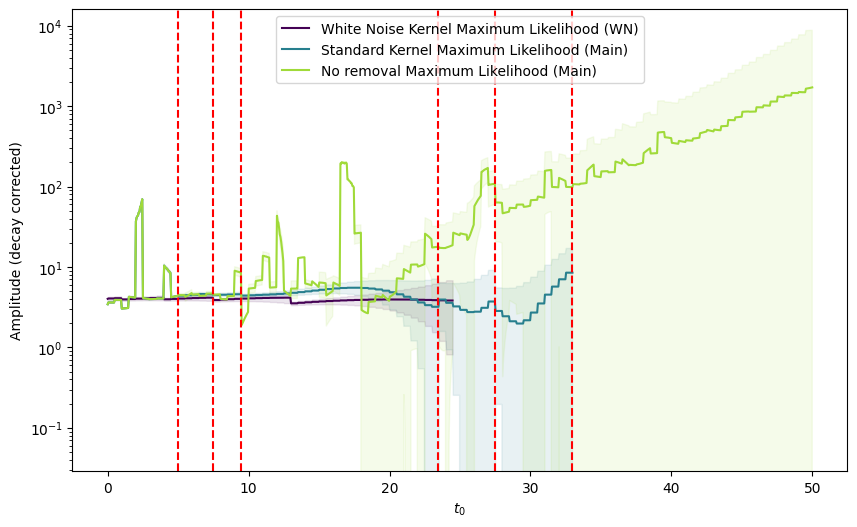

In [ ]:
colours = plt.cm.viridis(np.linspace(0, 3, len(QNM_LIST)))

fig, ax = plt.subplots(figsize=(10, 6))

view_qnms = [(2, 2, n, 1) for n in np.arange(1, 2)]
view_qnm_indices = [QNM_LIST.index(qnm) for qnm in view_qnms]

for i, (qnm, index) in enumerate(zip(view_qnms, view_qnm_indices)):
    #ax.plot(
    #    start_times, np.abs(amplitude_dict_ls_s[qnm])* np.exp(-omega_list[index].imag * (start_times)), color=colours[0], ls='--', 
    #    label="White Noise Kernel Least Squares"
    #)
    ax.plot(
        start_times, np.abs(amplitude_dict_ml_s[qnm]) * np.exp(-omega_list[index].imag * (start_times)), color=colours[0], ls='-',
        label="White Noise Kernel Maximum Likelihood (WN)"
    )
    ax.fill_between(
        np.array(start_times),
        (np.abs(amplitude_dict_ml_s[qnm]) - np.abs(amplitude_std_dev_dict_ml_s[qnm])) * np.exp(-omega_list[index].imag * (start_times)),
        (np.abs(amplitude_dict_ml_s[qnm]) + np.abs(amplitude_std_dev_dict_ml_s[qnm])) * np.exp(-omega_list[index].imag * (start_times)),
        color=colours[0],
        alpha=0.1
    )
    #ax.plot(
    #    start_times, np.abs(amplitude_dict_ls_m[qnm])* np.exp(-omega_list[index].imag * (start_times)), color=colours[1], ls='--', 
    #    label="Standard Kernel Least Squares"
    #)
    ax.plot(
        start_times, np.abs(amplitude_dict_ml_m[qnm])* np.exp(-omega_list[index].imag * (start_times)), color=colours[1], ls='-',
        label="Standard Kernel Maximum Likelihood (Main)"
    )
    ax.fill_between(
        np.array(start_times), 
        (np.abs(amplitude_dict_ml_m[qnm]) - np.abs(amplitude_std_dev_dict_ml_m[qnm])) * np.exp(-omega_list[index].imag * (start_times)), 
        (np.abs(amplitude_dict_ml_m[qnm]) + np.abs(amplitude_std_dev_dict_ml_m[qnm])) * np.exp(-omega_list[index].imag * (start_times)), 
        color=colours[1], alpha=0.1
    )
    #ax.plot(
    #    start_times, np.abs(amplitude_array_ls[:, index]) * np.exp(-omega_list[index].imag * (start_times)), color=colours[2], ls='--', 
    #    label="No removal Least Squares"
    #)
    ax.plot(
        start_times, np.abs(amplitude_array_ml[:, index]) * np.exp(-omega_list[index].imag * (start_times)), color=colours[2], ls='-',
        label="No removal Maximum Likelihood (Main)"
    )
    ax.fill_between(np.array(start_times), 
                    (np.abs(amplitude_array_ml[:, index]) - np.abs(amplitude_st_dev_array_ml[:, index])) * np.exp(-omega_list[index].imag * (start_times)), 
                    (np.abs(amplitude_array_ml[:, index]) + np.abs(amplitude_st_dev_array_ml[:, index])) * np.exp(-omega_list[index].imag * (start_times)), 
                    color=colours[2], alpha=0.1
                    )

    #ax.plot(
    #    start_times,
    #    np.abs(peak_amplitudes[index])
    #    * np.exp(omega_list[index].imag * (start_times)),
    #    linestyle=":",
    #    color=colours[index],
    #)

    # Find the first occurrence of NaN and draw a vertical line
    #nan_index_s = np.where(np.isnan(amplitude_dict_s[qnm]))[0][0]
    #nan_index = np.where(np.isnan(amplitude_dict[qnm]))[0][0]
    #ax.axvline(x=start_times[nan_index_s -1], color=colours[index], linestyle='--')
    #ax.axvline(x=start_times[nan_index - 1], color=colours[index], linestyle='--')
""" 
for i, qnm in enumerate(qnm_list):
    nan_indices_s = np.where(np.isnan(amplitude_dict_s[qnm]))[0]
    nan_indices = np.where(np.isnan(amplitude_dict[qnm]))[0]
    
    if len(nan_indices_s) > 0:
        ax.axvline(x=start_times[nan_indices_s[0]], color=colours[i], ls='-.')
    if len(nan_indices) > 0:
        ax.axvline(x=start_times[nan_indices[0]], color=colours[i], ls='--')
""" 

for t0, qnm_list_t0 in zip(start_times, qnm_list_timeseries_main):
    if t0 != start_times[0]:  # Skip the first t0 as there is no previous t0 to compare
        prev_qnm_list = qnm_list_timeseries_main[start_times.tolist().index(t0) - 1]
        if len(qnm_list_t0) != len(prev_qnm_list):
            print("Change in number of modes at t0 = ", t0)
            print("Change in modes: ", set(prev_qnm_list) - set(qnm_list_t0))
            ax.axvline(x=start_times[start_times.tolist().index(t0) - 1], color='red', linestyle='--')

ax.set_yscale("log")
#ax.set_ylim(1, 1e1)
#ax.set_xlim(T0, 30)
ax.set_xlabel(r"$t_0$")
ax.set_ylabel("Amplitude (decay corrected)")
ax.legend()
plt.savefig("amplitude_stability.pdf")
plt.show()